Компанії зацікавлені у відповіді на два питання:
    Чи буде маркетингова кампанія успішною?
    Якщо кампанія виявиться успішною, то яку частину цього успіху можна віднести на рахунок реклами?

Щоб відповісти на друге питання, зазвичай проводять A/B-тестування. Більшість людей зазнають впливу реклами (експериментальна група), тоді як невелика частина (контрольна група) замість цього побачить соціальну рекламу (PSA) або нічого, але в тому ж місці та того ж розміру, що й звичайна реклама.

Мета цього набору даних - проаналізувати групи, визначити, чи є різниця між групами статистично значущою.


План дій:
1. Огляд даних
2. Предобробка даних
3. Аналіз даних
4. Аналіз A/B тесту
5. Висновки

Доступні дані:
- user id: Ідентифікатор користувача (унікальний)
- test group: Якщо «ad» - людина бачила рекламу, якщо «psa» - тільки соціальну рекламу
- converted: Якщо людина купила товар, то True, інакше - False
- total ads: Кількість оголошень, які побачила людина
- most ads day: День, коли людина побачила найбільшу кількість оголошень
- most ads hour: Година дня, коли людина побачила найбільшу кількість оголошень

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

In [74]:
!ls

Untitled.ipynb	marketing_AB.csv


In [75]:
df = pd.read_csv('marketing_AB.csv')

# 1. Огляд даних

In [76]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [77]:
df.shape

(588101, 7)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [79]:
df.nunique()

Unnamed: 0       588101
user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64

In [80]:
for i in ['test group', 'converted', 'most ads day', 'most ads hour']:
    print(i, df[i].unique(), '\n')

test group ['ad' 'psa'] 

converted [False  True] 

most ads day ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday'] 

most ads hour [20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5] 



In [81]:
df.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279667,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [82]:
df.describe(include='object')

,test group,most ads day
count,588101,588101
unique,2,7
top,ad,Friday
freq,564577,92608


In [83]:
df.duplicated().sum()

0

# 2. Предобробка даних

In [84]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [85]:
df.columns = ['_'.join(i.split()) for i in df.columns]
df.columns

Index(['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')

In [86]:
df['converted'] = df['converted'] * 1

In [87]:
df['most_ads_day'].unique()

array(['Monday', 'Tuesday', 'Friday', 'Saturday', 'Wednesday', 'Sunday',
       'Thursday'], dtype=object)

In [88]:
week = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
        'Friday': 5, 'Saturday': 6, 'Sunday': 7}

df['most_ads_day'] = df['most_ads_day'].replace(week)

/tmp/ipykernel_585/1745619837.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['most_ads_day'] = df['most_ads_day'].replace(week)


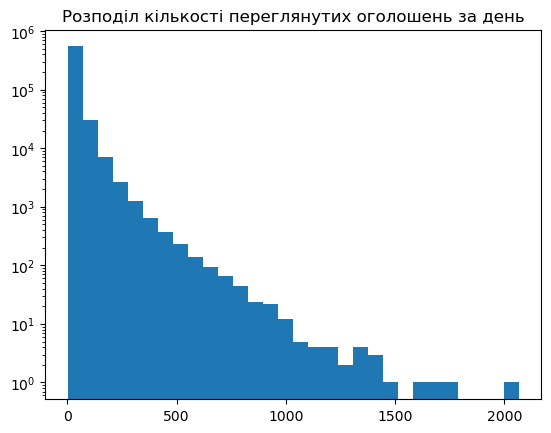

In [89]:
plt.hist(df['total_ads'], bins=30)

plt.title('Розподіл кількості переглянутих оголошень за день')
plt.yscale('log')
plt.show();

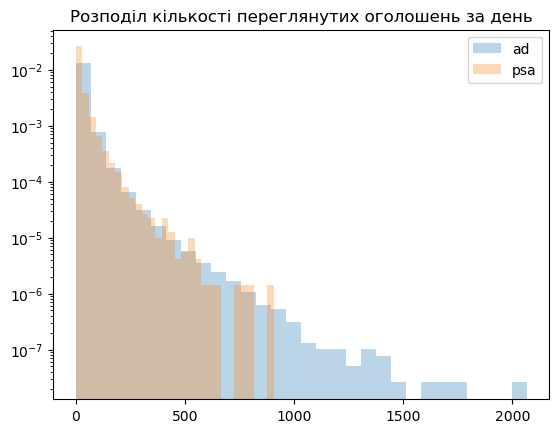

In [90]:
for i in df['test_group'].unique():
    plt.hist(df[df['test_group'] == i]['total_ads'], bins=30, alpha=0.3, density=True, label=i)

plt.title('Розподіл кількості переглянутих оголошень за день')
plt.legend()
plt.yscale('log')
plt.show();

Кількість переглянутої реклами на годину для тестової групи перевищує 1000, проте це не виглядає як викиди.

# 3. Аналіз даних

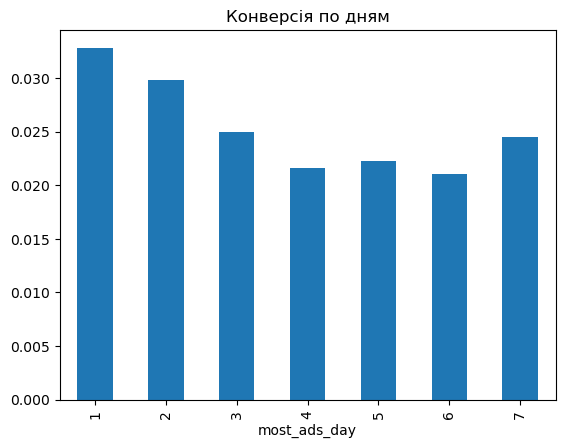

In [244]:
df.groupby('most_ads_day')['converted'].mean().plot(kind='bar')

plt.title('Конверсія по дням')
plt.show();

Конверсія починає зростати в неділю, досягає піку в понеділок, а потім поступово знижується. Четвер, п’ятниця та субота мають однаково найнижчу конверсію.

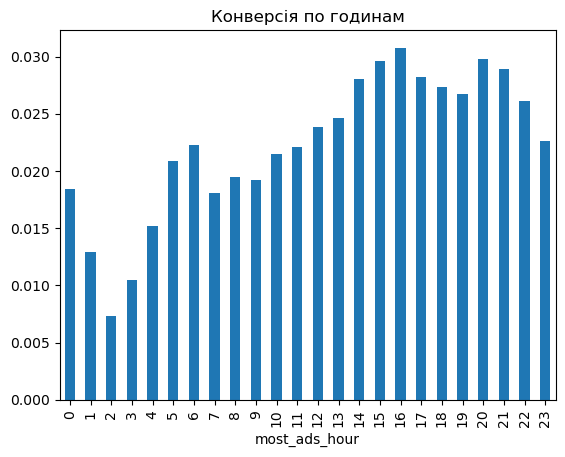

In [96]:
df.groupby('most_ads_hour')['converted'].mean().plot(kind='bar')

plt.title('Конверсія по годинам')
plt.show();

Якщо розглядати конверсію за часом доби, вона зростає і досягає піку о 15:00–16:00. Проте спостерігаються додаткові пікові значення о 4:00–6:00, 14:00–16:00 та 20:00–22:00, які вибиваються із загальної тенденції. Ймовірно, це пов’язано з наявністю користувачів з різних часових поясів, що робить графік менш плавним.

In [126]:
df['total_ads_bins'] = pd.qcut(df['total_ads'], 100, duplicates='drop')

/tmp/ipykernel_585/598429253.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('total_ads_bins')['converted'].mean().plot(kind='bar')


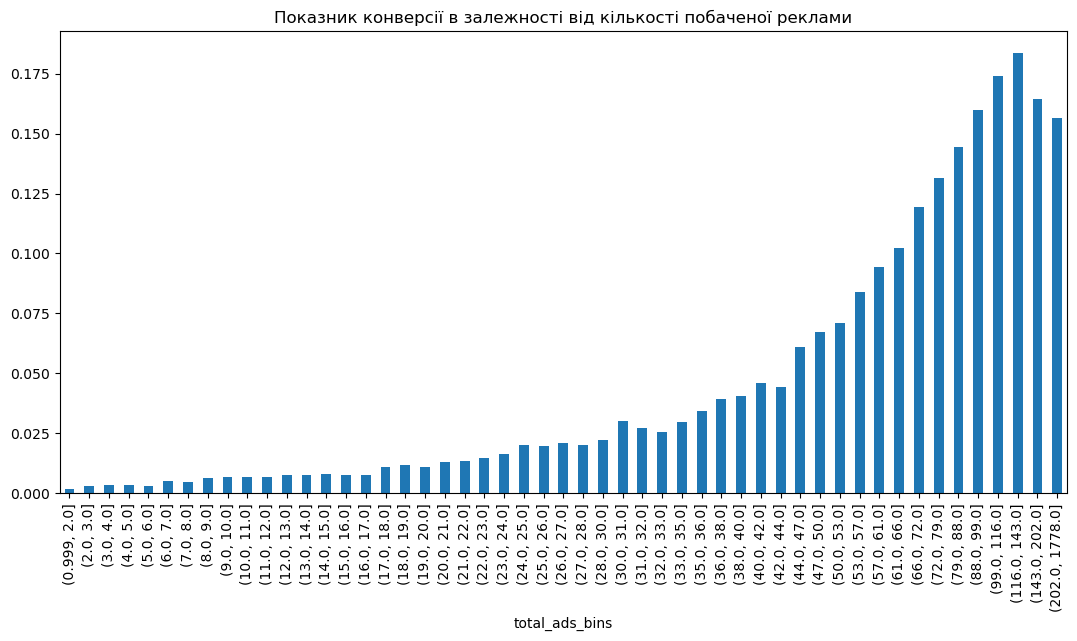

In [127]:
plt.figure(figsize=(13, 6))

df.groupby('total_ads_bins')['converted'].mean().plot(kind='bar')

plt.title('Показник конверсії в залежності від кількості побаченої реклами')
plt.show();

Спостерігається явна залежність конверсії від кількості переглянутої реклами: чим більше переглядів, тим вища конверсія. У діапазоні 116–143 переглядів вона досягає піку на рівні 18%. Однак після перевищення 143 переглядів конверсія починає знижуватися.

Без додаткової інформації складно визначити точну причину цього спаду. Можливо, користувачі відчувають перенасичення рекламою і просто перестають її помічати - так звана "банерна сліпота".

In [247]:
def bar_plot(df, grb_column, column='converted', title='', w=0.3):
    ad = df[df['test_group'] == 'ad'].groupby(grb_column)[column].mean()
    psa = df[df['test_group'] == 'psa'].groupby(grb_column)[column].mean()
    
    ad_index = ad.index
    psa_index = psa.index

    if ad_index.dtype != 'int64':
        ad_index = np.array([i for i, _ in enumerate(ad_index)])
        psa_index = np.array([i for i, _ in enumerate(psa_index)])

    w = w
    
    plt.bar(ad_index - w/2, height=ad, width=w, label='ad')
    plt.bar(psa_index + w/2, height=psa, width=w, label='psa')
    
    plt.title(title)
    plt.legend()
    plt.show();

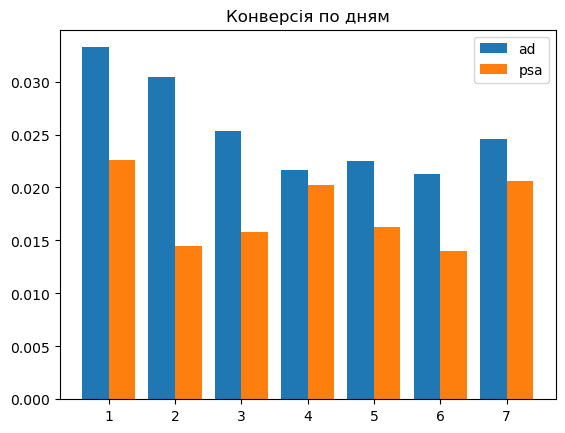

In [245]:
title = 'Конверсія по дням'
bar_plot(df, 'most_ads_day', title, 0.4)

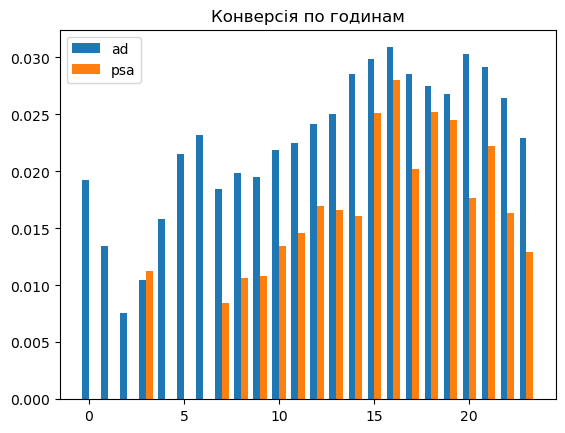

In [239]:
title = 'Конверсія по годинам'
bar_plot(df, 'most_ads_hour', title, 0.35)

In [274]:
x = df[(df['test_group'] == 'psa') & (df['most_ads_hour'].isin([i for i in range(7) if i != 3]))]

x.shape, x['converted'].mean(), x['most_ads_day'].sum()

((729, 7), 0.0, 3008)

Якщо аналізувати конверсію користувачів із контрольної групи за годинами, то в проміжку 00:00–07:00 вона зростає лише о 03:00, а в інший час її немає. У цьому проміжку часу (окрім 03:00) рекламу переглянули 3008 разів, але конверсія залишилася на рівні 0.

Можливо, це свідчить про некоректний розподіл користувачів між контрольною та тестовою групами. Ймовірно, більшість учасників контрольної групи належать до одного часового поясу, тоді як невелика частина – до іншого, що і пояснює сплеск конверсії о 03:00.

/tmp/ipykernel_585/4229280720.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ad = df[df['test_group'] == 'ad'].groupby(grb_column)['converted'].mean()
/tmp/ipykernel_585/4229280720.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  psa = df[df['test_group'] == 'psa'].groupby(grb_column)['converted'].mean()


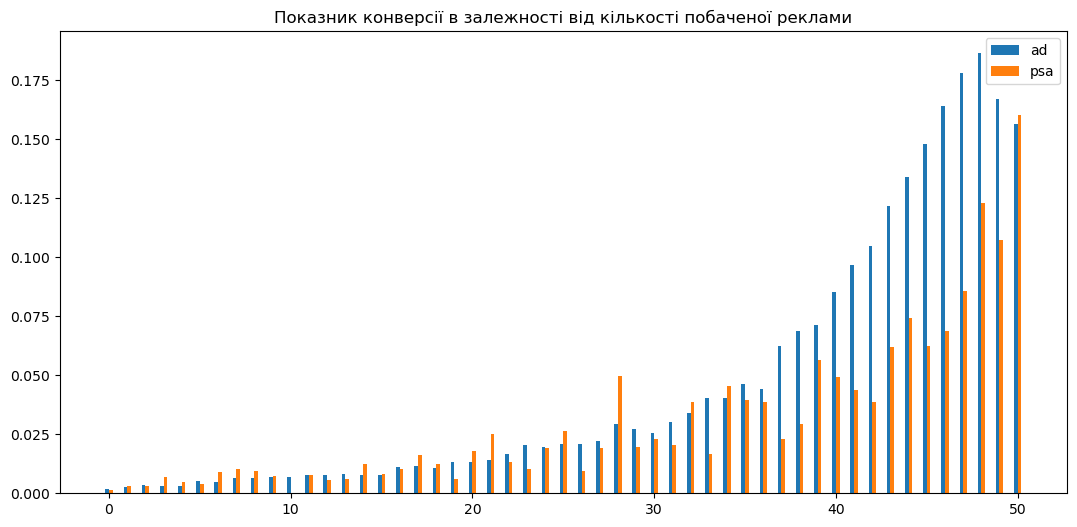

In [240]:
plt.figure(figsize=(13, 6))

title = 'Показник конверсії в залежності від кількості побаченої реклами'
bar_plot(df, 'total_ads_bins', title, 0.2)

In [264]:
df.groupby('total_ads_bins')['converted'].mean().index[28], \
    df.groupby('total_ads_bins')['converted'].mean().index[37], \
    df.groupby('total_ads_bins')['converted'].mean().index[49]

/tmp/ipykernel_585/4002321473.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('total_ads_bins')['converted'].mean().index[28], \
/tmp/ipykernel_585/4002321473.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('total_ads_bins')['converted'].mean().index[37], \
/tmp/ipykernel_585/4002321473.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('total_ads_bins')['converted'].mean().index

(Interval(30.0, 31.0, closed='right'),
 Interval(44.0, 47.0, closed='right'),
 Interval(143.0, 202.0, closed='right'))

Користувачі, які переглянули рекламу 44 і більше разів, демонструють вищу конверсію, у деяких випадках удвічі більшу, ніж ті, хто бачив лише простий банер.

Ті, хто переглянули рекламу менш ніж 44 рази, показують однаковий рівень конверсії.

Цікаво, що для користувачів, які переглянули рекламу 202 і більше разів, конверсія в обох групах залишається однаковою.

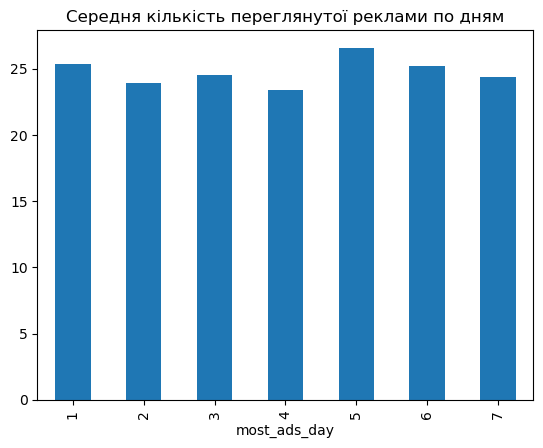

In [243]:
df.groupby('most_ads_day')['total_ads'].mean().plot(kind='bar')

plt.title('Середня кількість переглянутої реклами по дням')
plt.show();

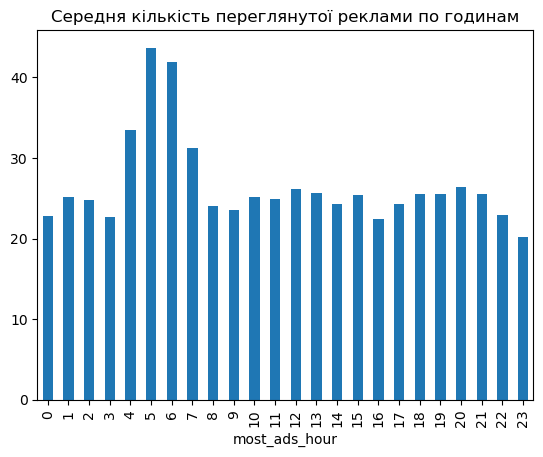

In [246]:
df.groupby('most_ads_hour')['total_ads'].mean().plot(kind='bar')

plt.title('Середня кількість переглянутої реклами по годинам')
plt.show();

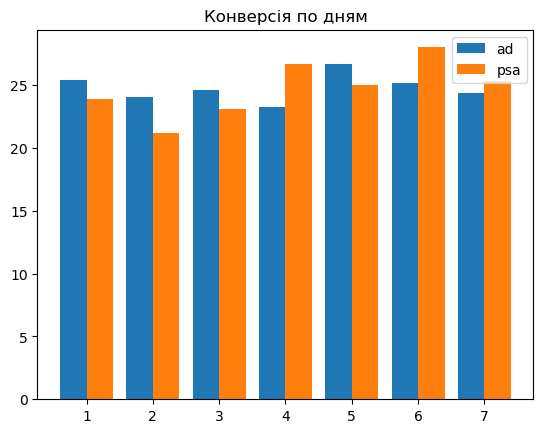

In [248]:
title = 'Конверсія по дням'
bar_plot(df, 'most_ads_day', 'total_ads', title, 0.4)

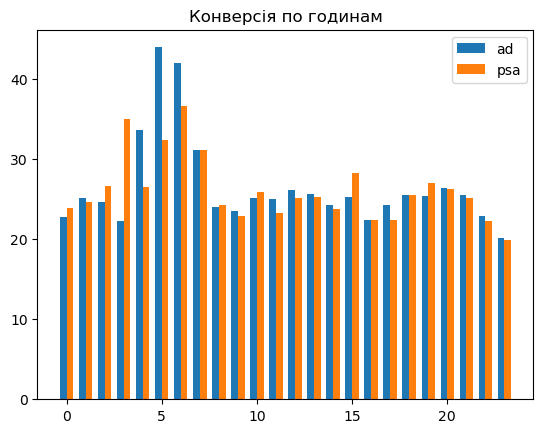

In [249]:
title = 'Конверсія по годинам'
bar_plot(df, 'most_ads_hour', 'total_ads', title, 0.35)

Протягом доби користувачі переглядають приблизно однакову кількість реклами, за винятком періоду 04:00–07:00, коли цей показник зростає в 1,5 раза.

Конверсія в цей час також підвищується, але не так суттєво. Це може свідчити про можливу наявність ботів або програм, які переглядають рекламу.

# 4. Аналіз A/B тесту

Сформулюємо гіпотези:
- H0: Реклама не має впливу на успіх кампанії, конверсія в експериментальній і контрольній групах не відрізняються статистично.
- H1: Реклама має вплив на успіх кампанії, конверсія в експериментальній і контрольній групах відрізняються статистично.

In [257]:
alpha = 0.05

a = df[df['test_group'] == 'psa']['converted']
b = df[df['test_group'] == 'ad']['converted']

z_stat, p_val = proportions_ztest([a.sum(), b.sum()], [a.count(), b.count()])

if p_val > alpha:
    print(f'{p_val:.2f} Нульову гіпотезу не відкидаємо, конверсія в експериментальній і контрольній групах не відрізняються статистично.')
else:
    print(f'{p_val:.2f} Нульову гіпотезу відкидаємо, конверсія в експериментальній і контрольній групах відрізняються статистично.')

0.00 Нульову гіпотезу відкидаємо, конверсія в експериментальній і контрольній групах відрізняються статистично.


Статистичний критерій показав p-value близьке до 0, що означає, що нульову гіпотезу відкидаємо, конверсія в експериментальній і контрольній групах відрізняються статистично.

# 5. Висновки

Аналіз даних показав, що кількість переглянутої реклами впливає на рівень конверсії, проте існує певний ліміт, після якого ефективність знижується, ймовірно, через ефект "банерної сліпоти". В діапазоні 44-202 переглянутої реклами, конверсія в експериментальній группі вища, в деяких випадках в 2 рази. Конверсія змінюється залежно від дня тижня та часу доби: максимальні значення спостерігаються в понеділок і в період 15:00–16:00, хоча є додаткові пікові значення, що можуть бути зумовлені різними часовими поясами користувачів.

Аномально висока активність у проміжку 04:00–07:00 та низька конверсія в контрольній групі можуть вказувати на проблеми з розподілом користувачів або навіть на присутність ботів. Аналіз статистичних даних підтвердив, що реклама має значний вплив на успіх кампанії, оскільки конверсія в експериментальній і контрольній групах відрізняється статистично, p-value близьке до 0.